**Imports**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import quad
from scipy.stats import norm
from iminuit import Minuit
import seaborn as sns
from tqdm import tqdm
import pandas as pd
from scipy.optimize import minimize
from matplotlib.ticker import AutoMinorLocator

colors = ['crimson','midnightblue', 'violet','orange','springgreen','dodgerblue','darkviolet', 'olive','tomato']
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colors)

**Common functions**

In [2]:
def func_gaussian(x, mu, sigma):
    return norm.pdf(x, mu, sigma)

**Mini Exercise**

In [3]:
random_normal_samples_1 , random_normal_samples_2 = [] , []

for x in range(4):
    random_normal_samples_1.append(np.random.normal(loc=1.25,scale=np.sqrt(0.11)))
    random_normal_samples_2.append(np.random.normal(loc=1.3,scale=np.sqrt(0.5)))
    
gauss_y_1 = func_gaussian(random_normal_samples_1,1.25,np.sqrt(0.11))
gauss_y_2 = func_gaussian(random_normal_samples_2,1.3,np.sqrt(0.5))

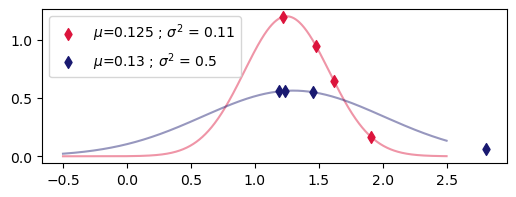

In [4]:
x_range = np.linspace(-0.5,2.5,1000)
plt.figure(figsize=(6,2))
plt.scatter(random_normal_samples_1,gauss_y_1,marker = 'd',label='$\mu$=0.125 ; $\sigma^2$ = 0.11')
plt.scatter(random_normal_samples_2,gauss_y_2,marker = 'd',label='$\mu$=0.13 ; $\sigma^2$ = 0.5')
plt.plot(x_range,func_gaussian(x_range,1.25,np.sqrt(0.11)), alpha = 0.45)
plt.plot(x_range,func_gaussian(x_range,1.3,np.sqrt(0.5)), alpha = 0.45)
plt.plot()
plt.legend()
plt.show()

In [5]:
x = [ 1.01, 1.30, 1.35, 1.44]
gauss_y1 = func_gaussian(x,1.25,np.sqrt(0.11))
gauss_y2 = func_gaussian(x,1.3,np.sqrt(0.5))

LH_1 = 1
LH_2 = 1

for i , j in zip(gauss_y1,gauss_y2):
    LH_1 *= i
    LH_2 *= j
    
print(f'Likelihood of Gauss A is {LH_1:.03} and of Gauss B is {LH_2:.03}')

Likelihood of Gauss A is 1.29 and of Gauss B is 0.0911


**Exercise 1**

In [6]:
r_gauss_exer1 = np.random.normal(loc=0.2,scale=0.1,size=50) # Generate 50 random numbers from Gaussian distribution

x_gauss_exer1 = func_gaussian(r_gauss_exer1,0.2,0.1) # Generate y-value from sampled Gauss values

LLH = np.sum(np.log(x_gauss_exer1)) # Compute the LLH by taking ln(x) of values and then sum
print(f'The LLH is {LLH:.03}. Remember this value will change with newly sampled values')

The LLH is 39.2. Remember this value will change with newly sampled values


In [7]:
mu_range = np.linspace(-0.2,0.6,100)
sigma_range = np.logspace(-1.5,0,100)

mu_sig_llh = []

for mu in mu_range: # Loop over mu values
    for sigma in sigma_range: # Loop over sigma values
        x_gauss_exer1 = func_gaussian(r_gauss_exer1,mu,sigma) # Compute y-values
        LLH = np.sum(np.log(x_gauss_exer1)) # Compute Log-Likelihood
        mu_sig_llh.append([mu,sigma,LLH]) # Append the mu, sigma and LLH
        
max_llh, max_index = max((sublist[-1], index) for index, sublist in enumerate(mu_sig_llh))

print(f'The greatest LLH is {max_llh}')

The greatest LLH is 39.75992788742686


In [8]:
df = pd.DataFrame(mu_sig_llh, columns=['$\mu$', '$\sigma$', 'Intensity'])
pivot_table = df.pivot(index='$\sigma$', columns='$\mu$', values='Intensity')

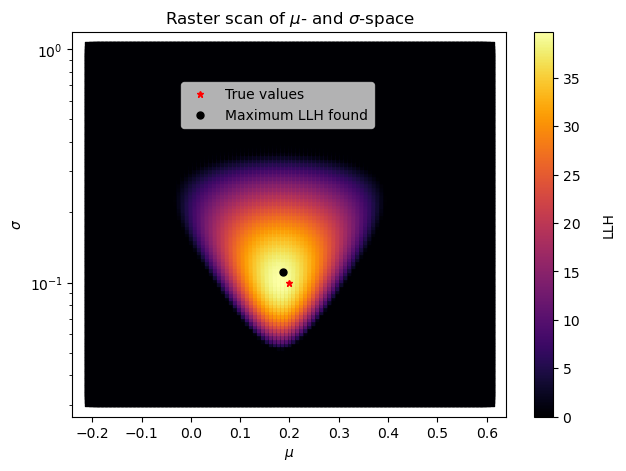

In [9]:
plt.figure(figsize = (7,5))
fig = plt.scatter(df['$\mu$'],df['$\sigma$'],c=df['Intensity'],marker = 's', s = 100, vmin = 0, cmap = 'inferno')

#the truth
plt.plot(0.2,0.1,marker='*',color='red',markersize=5,ls='none', 
       label = 'True values')

plt.plot(df['$\mu$'][max_index],df['$\sigma$'][max_index], marker = 'o', ls='none',
        color = 'black',markersize = 5, label = 'Maximum LLH found')

plt.xlabel('$\mu$')
plt.ylabel('$\sigma$')
plt.title('Raster scan of $\mu$- and $\sigma$-space')
plt.yscale('log')
plt.legend(loc = (0.25,0.75), fontsize = 10,framealpha=0.7,frameon=True)
plt.colorbar(fig,label='\nLLH')
plt.show()

In [10]:
scan_max_llh = []
true_max_llh = []

for i in (range(5)): # 100 trials
    
    x_samples = np.random.normal(loc=0.2,scale=0.1,size=50)

    LLHS = []
    
    for mu in mu_range: # Loop over mu values
        for sigma in sigma_range: # Loop over sigma values
                        
            x_gauss_exer1 = func_gaussian(x_samples,mu,sigma) # Compute y-values
            LLH = np.sum(np.log(x_gauss_exer1)) # Compute Log-Likelihood
            LLHS.append(LLH)

    true_gauss_y = func_gaussian(x_samples,0.2,0.1) # Compute y-values
    true_LLHS = np.sum(np.log(true_gauss_y)) # Compute Log-Likelihood
    
    scan_max_llh.append(np.max(LLHS))
    true_max_llh.append(true_LLHS)

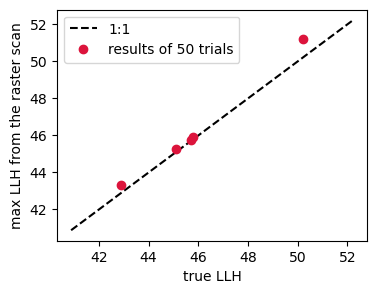

In [11]:
plt.figure(figsize=(4,3))
true_llh_arr = np.linspace(np.min(true_max_llh)-2,np.max(true_max_llh)+2,100)
plt.plot(true_llh_arr,true_llh_arr,ls='--',color='black',label = '1:1')
plt.plot(true_max_llh,scan_max_llh,ls='none',marker='o', label = 'results of %s trials'%50)
plt.xlabel('true LLH')
plt.ylabel('max LLH from the raster scan')
plt.legend(loc = 'upper left',frameon = True)

**Exercise 2**

In [12]:
def likelihood(x,alpha,beta):
    #we will transform this into a PDF right away...
    pdf = 1+alpha*x+beta*x**2
    #...remembering the PDF should be normalized! this is the definite integral over range -1..1
    norm = 2+(2*beta/3)
    #return the evaluated PDF only inside -1..1 range, and 0 outside
    return np.where(np.abs(x) <= 1, pdf/norm, 0.)

def log_likelihood(x,alpha,beta):
    #The log-likelihood to get all of the x-points (together) given our custom PDF with parameters alpha and beta.
    return np.sum(np.log(likelihood(x,alpha,beta)),axis=1)

def log_likelihood_2(x,alpha,beta):
    #The log-likelihood to get all of the x-points (together) given our custom PDF with parameters alpha and beta.
    return np.sum(np.log(likelihood(x,alpha,beta)),axis=0)

In [13]:
#true parameters of our PDF
true_alpha = 0.5
true_beta = 0.5

num_samples = 5000

#We will define a simple linear space in x and evaluate the PDF over this range.
xrange = np.linspace(-1,1,100)
pdf_curve = likelihood(xrange,true_alpha,true_beta)

#Next, we will find where the PDF evaluated on xrange has its maximum.
#This will be our upper boundary for the accept-reject box; the lower boundary is 0.
max_value = np.max(pdf_curve)
min_value = 0

#We sample uniformly from both x and the "pdf" (in reality just a variable that goes along the y-axis) to 
#populate the accept-reject box.
x_samples = np.random.uniform(-1,1,num_samples)
pdf_samples = np.random.uniform(min_value,max_value,num_samples)

#Then, we will actually evaluate the PDFs at our x_samples given the likelihood function we defined.
evaluated_pdfs_at_x = likelihood(x_samples,true_alpha,true_beta)
#The accept-reject test will be passed if our "pdf samples" are below the actual PDF.
accept_inds = np.where(evaluated_pdfs_at_x - pdf_samples > 0)[0]
reject_inds = np.where(evaluated_pdfs_at_x - pdf_samples < 0)[0]

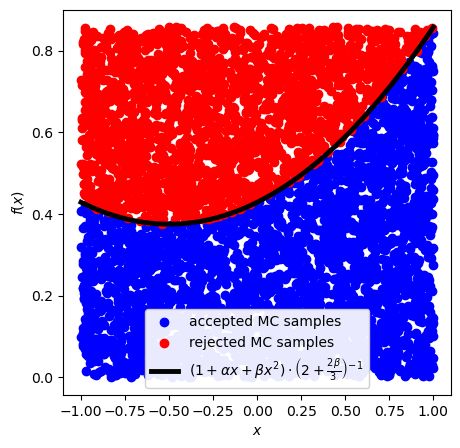

In [14]:
plt.figure(figsize = (5,5))

plt.scatter(x_samples[accept_inds],pdf_samples[accept_inds],color='blue',label = 'accepted MC samples')
plt.scatter(x_samples[reject_inds],pdf_samples[reject_inds],color='red', label = 'rejected MC samples')
plt.plot(xrange,pdf_curve, ls = '-', color = 'black', lw = 3.5, label = r'$(1 + \alpha x + \beta x^2)\cdot \left(2 + \frac{2\beta}{3}\right)^{-1}$')

plt.xlabel('$x$')
plt.ylabel('$f(x)$')

plt.legend(loc = 'lower center',frameon = True, framealpha = 0.92)

Text(0, 0.5, '$f(x)$')

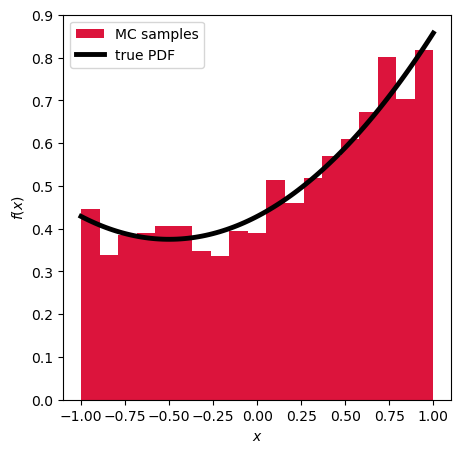

In [15]:
plt.figure(figsize = (5,5))
#we will be displaying the normalized histogram (density = True)...
plt.hist(x_samples[accept_inds],bins=np.linspace(-1,1,20),density=True,label = 'MC samples')

#...so that we can (again) plot the normalized the PDF on top of it:
plt.plot(xrange,pdf_curve, ls = '-', color = 'black', lw = 3.5, 
        label = r'true PDF')

plt.legend(loc = 'upper left',frameon = True)
plt.xlabel('$x$')
plt.ylabel('$f(x)$')

In [17]:
lambda_neg_LLH = lambda params: -log_likelihood(x_samples[accept_inds],
                                np.expand_dims([params[0]],axis=1),np.expand_dims([params[1]],axis=1))

res = minimize(lambda_neg_LLH,x0=[0.3,0.3],bounds=((-0.2,1),(0,1)),method='L-BFGS-B')
errors = np.sqrt(np.diag(res.hess_inv.todense()))

min_a , min_b = res['x']

print(f'After minimization, alpha was found to {min_a:.03} with error {errors[0]:.02} and beta to be {min_b:.03} with error {errors[1]:.02}')

After minimization, alpha was found to 0.53 with error 0.25 and beta to be 0.529 with error 0.25


In [28]:
np.shape(x_samples[accept_inds])

(2920,)

**Exercise 3**

In [19]:
new_true_alpha = 0.5
new_true_beta = 0.5

In [20]:
alpha_range = np.linspace(-0.2,1,100)
beta_range = np.linspace(0,1,100)

scanned_llh = []

for a in alpha_range:
    for b in beta_range:
        scanned_llh.append([a,b,log_likelihood_2(generated_samples,a,b)])

In [21]:
df = pd.DataFrame(scanned_llh, columns=[r'$\alpha$', r'$\beta$', 'Intensity'])
pivot_table = df.pivot(index=r'$\alpha$', columns=r'$\beta$', values='Intensity')

In [22]:
lambda_neg_LLH = lambda params: -log_likelihood(generated_samples,
                                np.expand_dims([params[0]],axis=1),np.expand_dims([params[1]],axis=1))

path = []  # This list will store the path of the optimizer
def callback(x):
    path.append(x.copy())

res = minimize(lambda_neg_LLH,x0=[0.05,0.05],bounds=((-0.2,1),(0,1)),method='L-BFGS-B',callback=callback)
res['x']

array([0.58182207, 0.41860242])

In [23]:
path_alpha = [arr[0] for arr in path]
path_beta  = [arr[1] for arr in path]

In [24]:
alphas , betas , llhs = df[r'$\alpha$'].values , df[r'$\beta$'].values , df['Intensity'].values 

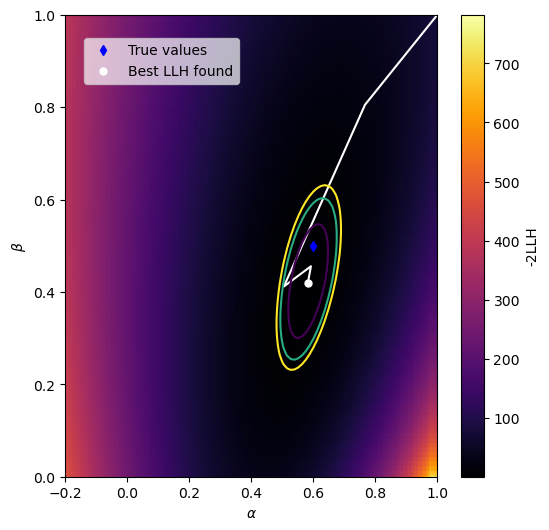

In [25]:
plt.figure(figsize = (6,6))

#raster scan results
sc = plt.scatter(df[r'$\alpha$'],df[r'$\beta$'],c=-2*(df['Intensity']+res.fun),
               marker = 's', s = 100, cmap = 'inferno')

plt.plot(path_alpha,path_beta,color='white')

#the truth
plt.plot(new_true_alpha,new_true_beta,marker='d',color='blue',markersize=5,ls='none', 
       label = 'True values')

#the minimizer results: best-fitting alpha,beta parameters
plt.plot(res.x[0],res.x[1],marker='o',color='white',markersize=5,ls='none', 
       label = 'Best LLH found')

contours = plt.contour(alphas.reshape(len(alpha_range),len(beta_range)),
           betas.reshape(len(alpha_range),len(beta_range)),
          -2*(llhs+res.fun).reshape(len(alpha_range),len(beta_range)),
           [2.3,4.6,6])


plt.legend(loc = (0.05,0.85), fontsize = 10,framealpha=0.7,frameon=True)
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\beta$')

cb = plt.colorbar(sc,label=r'-2LLH')